In [1]:
%config IPCompleter.greedy = True
#System
import time
import re
import itertools

#processing
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


from sklearn.preprocessing import MultiLabelBinarizer

#feature
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier, Perceptron, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

#Evaluation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, fbeta_score

#Report
import matplotlib.pyplot as plt   
import seaborn as sns


In [2]:
#load data
dataFrameTraining = pd.read_csv("data/Toxic_train_set.csv")
dataFrameTesting = pd.read_csv("data/Toxic_test_set.csv")

dftr = dataFrameTraining
dfte = dataFrameTesting

train_documents = tuple(dftr['Comments'])
test_documents = tuple(dfte['Comments'])

all_categories = ["obscene", "threat", "insult", "hate", "Intolerant"]

In [3]:
df_toxic = dftr.drop(['Comments'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,obscene,38
1,threat,47
2,insult,34
3,hate,16
4,Intolerant,69


Text(0.5,0,'category')

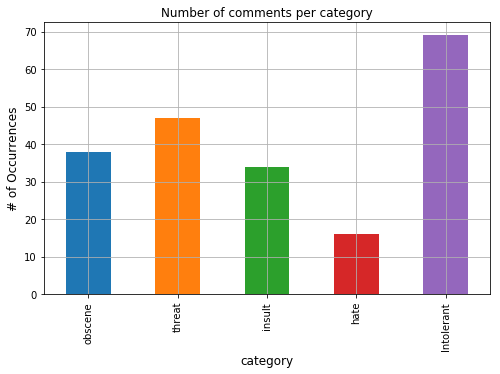

In [4]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

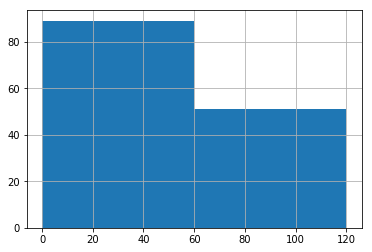

In [5]:
lens = dftr.Comments.str.len()
lens.hist(bins = np.arange(0,150,60))

Text(0.5,0,'# of categories')

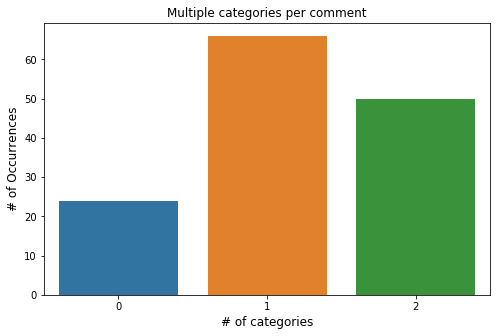

In [6]:
#how many labels per example
rowsums = dftr.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [7]:
def getLabelList(data):
    categories = []
    for i in range(len(data)):            
        tempList = []
        for category in all_categories:        
            if data[category][i] == 1:
                tempList.append(category)   
        #print(tempList, i)
                #print(data[category][i], category, i)            
        categories.append(tempList)
    return categories

In [8]:
# making labels single list
train_categories = tuple(getLabelList(dftr))
test_categories = tuple(getLabelList(dfte))

### Tokenizing Sample
<p> After setting Train and Test dataset with crossponding classes. Now we made tokenzie function. This function removes stop words and tokenzie each samples using nltk word_tokenize function. The return result will be in list type </p> 

In [9]:
cachedStopWords = stopwords.words("english")
def tokenize(text):    
    min_length = 3
    words = map(lambda word: word.lower(), nltk.word_tokenize(text))
    words = [word for word in words if word not in cachedStopWords]
    tokens = (list(map(lambda token: PorterStemmer().stem(token), words)))
    p = re.compile('[a-zA-Z]+')
    filtered_tokens = list(filter(lambda token: p.match(token) and
                                  len(token) >= min_length, tokens))
    return filtered_tokens

### tf_idf feature extraction process
<p> Here we call <b>tokenize</b> function. We have <b>max_feature</b> of 105 . Then we crate callTf_idf object for that function having parameter train_document</p>

In [10]:
def tf_idf(docs):
    tfidf = TfidfVectorizer(tokenizer=tokenize, max_features=105, use_idf=True, sublinear_tf=True)
    tfidf.fit(docs)
    return tfidf
representer = tf_idf(train_documents)

### Text Processing Functions
<p> Transform between iterable of iterables and a multilabel format </p>

In [11]:
mlb = MultiLabelBinarizer()

def get_train_set():
    return representer.transform(train_documents),\
        mlb.fit_transform(train_categories)

def get_test_set():
    return representer.transform(test_documents),\
        mlb.fit_transform(test_categories)

### Storing sets of data

In [12]:
X_train, Y_train = get_train_set()
X_test, Y_test = get_test_set()

In [13]:
if not isinstance(X_train, np.ndarray) and isinstance(X_test, np.ndarray):
    X_train = X_train.toarray()
    X_test = X_test.toarray()

### Combine Classifiers
<p> Here we uses different classifcation classifers on OnveVsRestClassifier from sklearn </p>

In [14]:
classifiers = [
    ('DecisionTreeClassifier', OneVsRestClassifier(DecisionTreeClassifier())),
    ('LinearSVC', OneVsRestClassifier(LinearSVC(random_state=23))),        
    ('LogisticRegression', OneVsRestClassifier(LogisticRegression())),    
    ('LogisticRegressionCV', OneVsRestClassifier(LogisticRegressionCV())),
    ('SGDClassifier', OneVsRestClassifier(SGDClassifier())),
    ('Perceptron', OneVsRestClassifier(Perceptron())),
    ('RidgeClassifierCV', OneVsRestClassifier(RidgeClassifierCV())),
    ('RandomForestClassifier', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, n_jobs=10))),        
    ('AdaBoostClassifier', OneVsRestClassifier(AdaBoostClassifier())),    
    ('ExtraTreesClassifier', OneVsRestClassifier(ExtraTreesClassifier())),        
    ('KNeighborsClassifier', OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))),    
    ('MLPClassifier', OneVsRestClassifier(MLPClassifier())),    
]

### Classifier Training
<p> In for loop we trained our list of classifers and results are stored in cls_dict dictionary. We train our classifier with with train dataset and test with test dataset. Evaluation is done in test dataset</p>

In [15]:
print(("{clf_name:<30}: {score:<5}  in {train_time:>5} /  {test_time}")
      .format(clf_name="Classifier", score="score", train_time="train", test_time="test"))
print("-" * 80)
cls_dict = {}
for clf_name, classifier in classifiers:
    t0 = time.time()
    y_pred = classifier.fit(X_train, Y_train)
    cls_dict.update({clf_name: y_pred})
    t1 = time.time()
    
    preds = classifier.predict(X_test)
    preds[preds >= 0.5] = 1
    preds[preds < 0.5] = 0    
    t2 = time.time()

    acc = accuracy_score(y_true=Y_test, y_pred=preds)
    f1 = fbeta_score(y_true=Y_test, y_pred=preds, beta=1, average="weighted")
    print(("{clf_name:<30}: {acc:0.2f}% {f1:0.2f}% in {train_time:0.2f}s"
           " train / {test_time:0.2f}s test")
          .format(clf_name=clf_name,
                  acc=(acc * 100),
                  f1=(f1 * 100),
                  train_time=t1 - t0,
                  test_time=t2 - t1))       

Classifier                    : score  in train /  test
--------------------------------------------------------------------------------
DecisionTreeClassifier        : 91.94% 97.26% in 0.03s train / 0.00s test
LinearSVC                     : 93.55% 97.87% in 0.02s train / 0.00s test
LogisticRegression            : 50.00% 76.45% in 0.09s train / 0.00s test
LogisticRegressionCV          : 93.55% 97.87% in 1.19s train / 0.00s test
SGDClassifier                 : 79.03% 92.88% in 0.05s train / 0.00s test
Perceptron                    : 82.26% 94.27% in 0.02s train / 0.00s test
RidgeClassifierCV             : 87.10% 95.99% in 0.10s train / 0.00s test


C:\Users\subash\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\subash\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\subash\Anaconda3\lib\

RandomForestClassifier        : 75.81% 91.12% in 2.27s train / 0.68s test
AdaBoostClassifier            : 98.39% 99.46% in 0.97s train / 0.05s test
ExtraTreesClassifier          : 83.87% 93.57% in 0.16s train / 0.02s test
KNeighborsClassifier          : 40.32% 75.57% in 0.01s train / 0.02s test


C:\Users\subash\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\subash\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\subash\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\subash\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

MLPClassifier                 : 74.19% 91.37% in 4.21s train / 0.00s test


C:\Users\subash\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Choosing best Classifier -  Classifier Evaluation
<p> Out of 4 classifer scores we choosed best which is LinearSVC. LinearSVC is Linear Support Vector Classification. Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples. This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme. Rest of evaluation precision, recall are also produce here</p>

In [16]:
# a,p,r,f1

Y_test_predict = cls_dict['AdaBoostClassifier'].predict(X_test)

[precision, recall, F1, support] = \
precision_recall_fscore_support(Y_test, Y_test_predict, average='samples')
accuracy = accuracy_score(Y_test, Y_test_predict)
print("Accuracy: {}, Precision: {},Recall: {}, F1: {}".format(accuracy, precision, recall, F1))

Accuracy: 0.9838709677419355, Precision: 0.9596774193548387,Recall: 0.967741935483871, F1: 0.9623655913978494


C:\Users\subash\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\subash\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


# prob

In [17]:
print(cls_dict['RandomForestClassifier'].predict(X_test[1]))
print(cls_dict['RandomForestClassifier'].predict_proba(X_test[1]))    

[[1 0 0 0 1]]
[[0.99 0.   0.01 0.01 0.98]]


In [18]:
def rawPrediction(getText, model):
    example_text = [getText]
    vectorised_testing_new = representer.transform(example_text)
    getPredictionVector = model.predict(vectorised_testing_new)
    getPredictionVectorProba = model.predict_proba(vectorised_testing_new)
    example_labels = mlb.inverse_transform(getPredictionVector)
    return example_labels, vectorised_testing_new, getPredictionVectorProba

In [22]:
# predict new text
labels = ['Intolerant', 'hate', 'insult', 'obscene', 'threat']
#newText = test_documents[13]
#example_text = " I dislike you and will kill you raifd. You pervert stupid muslim"
#example_text = "Amit, you pervert. I will kill you stupid"
#example_text = "They are not pervert and stupid"
example_text = "Amit you are pervert. I dislike anything you do you stupid."
#example_text = "Muslim are good"
#example_text = "Muslim are not stupid!"
#example_text = "The world is beautiful, take time to realize it"
#example_text = 'stupid, fuck, suck, kill, dislike'
#example_text = "They are pervert and stupid"
#example_text = "Amit, you pervert. I will kill you stupid"

newText = example_text
predictionLables, v, p = rawPrediction(newText, cls_dict['AdaBoostClassifier'])
print("Example text: {}".format(newText))
print("Predicted labels: {}".format(''.join(map(str, predictionLables))))

print("\n")
for label, proba in zip(labels, p[0]):    
    print("{} : {}".format(label, round(proba,2)))

Example text: Amit you are pervert. I dislike anything you do you stupid.
Predicted labels: ('hate', 'insult', 'obscene')


Intolerant : 0.38
hate : 1.0
insult : 0.89
obscene : 0.86
threat : 0.15


### Ploting Confusion Matrix
<p> We have choosed only 13 classes to generate confusion matrix this value is changable </p>

In [87]:
#creating a confusion matrix
#note:
#import sklearn.metrics.multilabel_confusion_matrix
#https://stackoverflow.com/questions/48872738/understanding-multi-label-classifier-using-confusion-matrix
    

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    print(cm)
    plt.figure(num=None, figsize=(10, 10), dpi=70, facecolor='w', edgecolor='k')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    # Setup labels 
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout() 
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [88]:
ConfusionMatrix = confusion_matrix(Y_test.argmax(axis=1), Y_test_predict.argmax(axis=1))

[[27  1  1  4  0]
 [ 2  2  0  0  0]
 [ 1  0  6  0  0]
 [ 2  0  0  6  0]
 [ 6  0  0  0  4]]


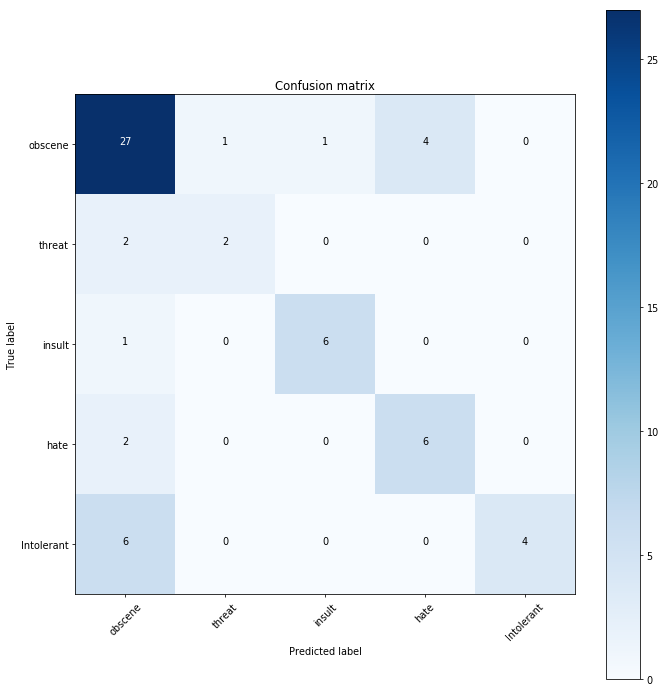

In [91]:
plot_confusion_matrix(ConfusionMatrix, classes=all_categories, title='Confusion matrix')
plt.show()

<p> All correct predictions are located in the diagonal of the table (highlighted in blue color), so it is easy to visually inspect the table for prediction errors, as they will be represented by values outside the diagonal. </p>